+---+------------------------------+--------------------+--------------------+--------------------+
|   |            Model             |      Accuracy      |     Precision      |       Recall       |
+---+------------------------------+--------------------+--------------------+--------------------+
| 0 |    Gradient Boosting (GB)    | 0.509090909090909  | 0.5881168831168831 | 0.509090909090909  |
| 1 |      Random Forest (RF)      | 0.5454545454545454 | 0.5934165834165833 | 0.5454545454545454 |
| 2 | Bayesian Consensus (GB + RF) |        0.6         | 0.6503896103896104 |        0.6         |
+---+------------------------------+--------------------+--------------------+--------------------+


/var/folders/my/y85t9bq97r5c14mjm7r8ncbm0000gp/T/ipykernel_74639/3911403168.py:193: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted,


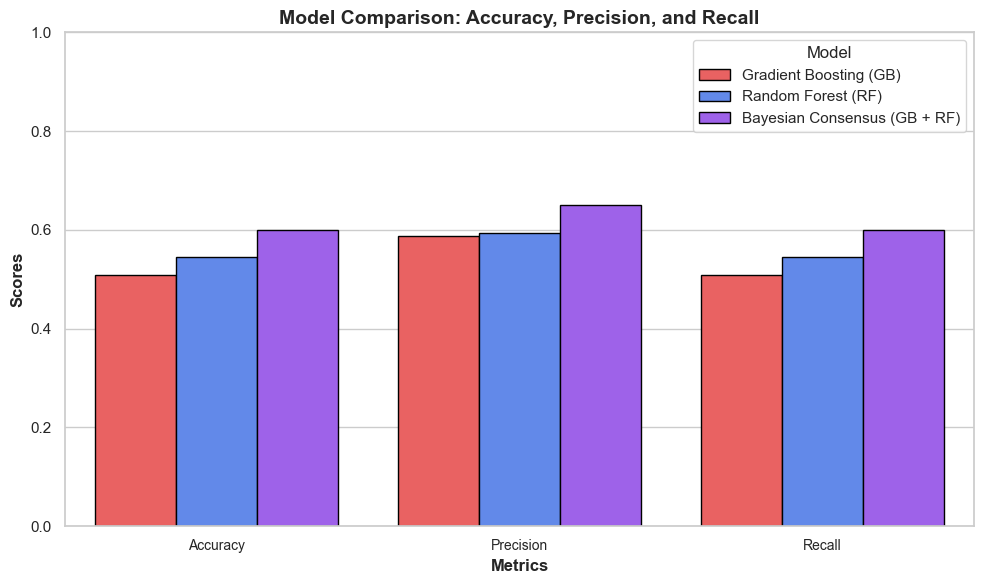

In [ ]:
#Imports
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

#Import Data 
df = pd.read_csv("final_embeddings_with_class.csv")
df.head()

#Seperate Features and Labels 
X = df.drop("class", axis=1)
y=df['class']

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Initialize Gradient Boosting Classifier
gradient_boost = GradientBoostingClassifier()

#SHOW GRAPH OF ERROR REDUCTION PER MODEL 

#Initialize Grid Search Parameters 
parameters_gb = {
    'n_estimators': [100, 500, 1000], 
    'warm_start': [False],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_iter_no_change': [10],
    'random_state': [42]
}

#Grid Search to Find Optimal Hyperparameters
grid_search_gb = GridSearchCV(estimator=gradient_boost, param_grid=parameters_gb, cv=5, scoring='accuracy') 

#Train the Model
grid_search_gb.fit(X_train, y_train)

#Obtain Optimal Models
best_model_gb = grid_search_gb.best_estimator_

#Predict on the Test Set
y_test_pred_gb = best_model_gb.predict(X_test)

#Compute Accuracy on the Testing Set
gb_test_accuracy = accuracy_score(y_test, y_test_pred_gb)
gb_precision, gb_recall, gb_f1, _ = precision_recall_fscore_support(y_test, y_test_pred_gb, average='weighted')


#Initialize Gradient Boosting Classifier
random_forest = RandomForestClassifier()

parameters_rf = {
    'n_estimators': [100, 500, 1000], 
    'max_depth': [None, 10, 20, 30],
    'random_state': [42]
}

#Grid Search to Find Optimal Hyperparameters
grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=parameters_rf, cv=5, scoring='accuracy') 

#Train the Model
grid_search_rf.fit(X_train, y_train)

#Obtain Optimal Models
best_model_rf = grid_search_rf.best_estimator_

#Predict on the Test Set
y_test_pred_rf = best_model_rf.predict(X_test)

#Compute Accuracy on the Testing Set
rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(y_test, y_test_pred_rf, average='weighted')

#Bayesian Consensus - Serial High-Level Fusion
def bayesian_consensus(confusion_matrices, y_test_pred, rf_predictions, evidence):

    likelihood_cm= []

    for cm in confusion_matrices:

        #Convert Confusion Matrices to Likelihood Estimates (Taken from chatgpt)
        cm_sum_per_class = cm.sum(axis=1, keepdims=True)  # Sum per class (rows)
        likelihood = cm / cm_sum_per_class  # Normalize each row to sum to 1
        likelihood_cm.append(likelihood)

    bay_predictions = []
    len_of_predictions = len(y_test_pred)

    #For all predictions 
    for j in range(len_of_predictions):

        #Initialize Prior Probabilities to have equal probability of occurring (p_hg for classes [1,2,3,4,5,6,7])
        p_hg = [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]

        #Initialize posterior probabilities 
        p = [0,0,0,0,0,0,0]

        s=0
        e = evidence[s][j]
        #For each model 
        for m in likelihood_cm:

            for i in range(1,8):

                # p(h_g|e) = p(e|h_g) * p(h_g)/ sum_g(p(e|h_g) * p(h_g)) - Calculate Probability that True Value is Class x given the Prediction is Class y -> Becomes New Posterior Probability for Class x

                # p(e|h_g) * p(h_g)
                numerator = m[i-1, e-1]*p_hg[i-1]

                # sum_g (p(e|h_g) * p(h_g))
                denominator = np.sum([
                    m[0, e-1]*p_hg[0], 
                    m[1, e-1]*p_hg[1], 
                    m[2, e-1]*p_hg[2], 
                    m[3, e-1]*p_hg[3], 
                    m[4, e-1]*p_hg[4],
                    m[5, e-1]*p_hg[5], 
                    m[6, e-1]*p_hg[6]])
            
                #Collect Posterior Probabilities
                p[i-1] = numerator/denominator

                #Make next iterations prior probabilities the posterior probabilites from the previous iteration
                p_hg[i-1] = p[i-1]

            s=s+1
            if s < len(evidence):
                e = evidence[s][j]

        bay_predictions.append(np.argmax(p)+ 1)
    
    return bay_predictions

#Compute Confusion Matrix For Gradient Boost Model
cm_gb = confusion_matrix(y_test, y_test_pred_gb)
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
confusion_matrices = [cm_gb, cm_rf]
evidence = [y_test_pred_gb, y_test_pred_rf]
px = bayesian_consensus(confusion_matrices, y_test_pred_gb, y_test_pred_rf, evidence)

# Calculate the number of correct predictions
correct_matches = sum([1 for true, predicted in zip(y_test, px) if true == predicted])

# Calculate the accuracy
bc_accuracy = correct_matches / len(y_test)
bc_precision, bc_recall, bc_f1, _ = precision_recall_fscore_support(y_test, px, average='weighted')

#Formatting from Chatgpt

# Create the data
data = [
    ["Gradient Boosting (GB)", gb_test_accuracy, gb_precision, gb_recall],
    ["Random Forest (RF)", rf_test_accuracy, rf_precision, rf_recall],
    ["Bayesian Consensus (GB + RF)", bc_accuracy, bc_precision, bc_recall],
]

# Define the headers
headers = ["Model", "Accuracy", "Precision", "Recall"]

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data, columns=headers)

# Print the table using tabulate
print(tabulate(df, headers, tablefmt="pretty"))

# Reshape the DataFrame to "long" format using pandas melt
df_melted = df.melt(id_vars=["Model"], value_vars=["Accuracy", "Precision", "Recall"],
                    var_name="Metric", value_name="Score")

# Set up the seaborn style
sns.set(style="whitegrid")

# Set up the figure for a single bar chart with grouped bars
plt.figure(figsize=(10, 6))

# Create the grouped bar plot using Seaborn
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted,
            ci=None, edgecolor='black', palette=["#FF4C4C", "#4C80FF", "#9B4CFF"])

# Customize the chart
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Scores', fontsize=12, fontweight='bold')
plt.title('Model Comparison: Accuracy, Precision, and Recall', fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0, fontsize=10)

# Adjust the y-axis limits to range from 0 to 1
plt.ylim(0, 1)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
